In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
from joblib import Parallel, delayed
from sklearn import preprocessing, model_selection
import lightgbm as lgb
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

path_root = '../../../data'
path_data = '../../../data'
path_submissions = '/'
target_name = 'target'
scores_folds = {}

In [2]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def log_1_return(items):
    items = items + 1
    return np.log(items + 1).diff()

def realized_volatility(series_log_return):
    return (np.sqrt(np.sum(series_log_return**2)))

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred)/y_true)))

def get_stock_stat(stock_id: int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    # stock features
    df_book = pd.read_parquet(path_root+f'/book_{dataType}.parquet/stock_id={stock_id}')
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    df_book['wap1'] = (df_book['bid_price1']*df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1']) / (
                            df_book['ask_size1'] + df_book['bid_size1'])
    df_book['wap2'] = (df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size2'] + df_book['bid_size2'])
    
    df_book['wap3'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1'] + df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size1'] + df_book['bid_size1'] + df_book['ask_size2'] + df_book['bid_size2'])
    
    features_to_apply_realized_volatility = []
    for i in range(1, 4):
        df_book[f'log_return{i}'] = df_book.groupby(by=['time_id'])[f'wap{i}'].apply(log_return).fillna(0)
        features_to_apply_realized_volatility += [f'log_return{i}']
        
    # WAP difference and mean
    for i in range(1, 4):
        for j in range(i+1, 4):
            if not i + j == 4 or not i+ j == 5:
                mean_name = f'book_wap{i}_{j}_mean'
                diff_name = f'book_wap{i}_{j}_diff'

                df_book[mean_name] = (df_book[f'wap{i}'] + df_book[f'wap{j}']) / 2
                df_book[diff_name] = df_book[f'wap{i}'] - df_book[f'wap{j}']

                features_to_apply_realized_volatility += [mean_name, diff_name]

            
    # other orderbook features
    df_book['book_price_spread1'] = (df_book['ask_price1'] - df_book['bid_price1']) / (df_book['ask_price1'] + df_book['bid_price1'])
    df_book['book_price_spread2'] = (df_book['ask_price2'] - df_book['bid_price2']) / (df_book['ask_price2'] + df_book['bid_price2'])
#     df_book['book_bid_spread'] = df_book['bid_price1'] - df_book['bid_price2']
#     df_book['book_bid_spread_a'] = (df_book['bid_price1'] - df_book['bid_price2']) / (df_book['bid_price1'] + df_book['bid_price2'])
    df_book['book_ask_spread'] = df_book['ask_price1'] - df_book['ask_price2']
#     df_book['book_ask_spread_a'] = (df_book['ask_price1'] - df_book['ask_price2']) / (df_book['ask_price1'] + df_book['ask_price2'])
#     df_book['book_total_volume'] = df_book['ask_size1'] + df_book['ask_size2'] + df_book['bid_size1'] + df_book['bid_size2']
#     df_book['book_volume_imbalance'] = (df_book['ask_size1'] + df_book['ask_size2']) - (df_book['bid_size1'] + df_book['bid_size2'])
    features_to_apply_realized_volatility += ['book_price_spread1', 'book_price_spread2',
                                              'book_ask_spread']
            
        
    # Ryotaro Features
    df_book['typical_price'] = (df_book['bid_price1'] + df_book['ask_price1'] + df_book['wap1']) / 3
    df_book['TypicalPrice_log_return'] = df_book.groupby(by=['time_id'])['typical_price'].apply(log_return).fillna(0)
    features_to_apply_realized_volatility += ['TypicalPrice_log_return']
    
    stock_stat = df_book.groupby(by=['stock_id', 'time_id'])[features_to_apply_realized_volatility].agg(realized_volatility).reset_index()
    
    # trade features
    trade_stat = pd.read_parquet(path_root + f'/trade_{dataType}.parquet/stock_id={stock_id}')
    trade_stat = trade_stat.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    trade_stat['stock_id'] = stock_id
    cols = key + [col for col in trade_stat.columns if col not in key]
    trade_stat = trade_stat[cols]
    
    trade_features_realized_volatility = []
    trade_features_realized_volatility += ['trade_log_return']
    trade_stat['trade_log_return'] = trade_stat.groupby(by=['time_id'])['price'].apply(log_return).fillna(0)
    
    # trade original features
    trade_stat['size_log_return'] = trade_stat.groupby(by='time_id')['size'].apply(log_1_return).fillna(0)
#     trade_stat['orderCount_log_return'] = trade_stat.groupby(by='time_id')['order_count'].apply(log_1_return).fillna(0)
#     trade_stat['volume'] = trade_stat['price'] * trade_stat['order_count']
#     trade_stat['volume_log_return'] = trade_stat.groupby(by='time_id')['volume'].apply(log_1_return).fillna(0)
    trade_features_realized_volatility += ['size_log_return']
    
    trade_stat = trade_stat.groupby(by=['stock_id', 'time_id'])[trade_features_realized_volatility].agg(realized_volatility).reset_index()
    
    # joining book and trade features
    stock_stat = stock_stat.merge(trade_stat, on=['stock_id', 'time_id'], how='left').fillna(-999)
    return stock_stat

def get_dataSet(stock_ids: list, dataType='train'):
    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType)
        for stock_id in stock_ids
    )
    stock_stat_df = pd.concat(stock_stat, ignore_index=True)
    
    return stock_stat_df

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true=labels, y_pred=preds), 5), False

params_lgbm = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric': 'None',
    'max_depth': -1,
    'n_jobs': -1,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'lambda_l2': 1,
    'verbose': -1
}

In [3]:
# Train data
train = pd.read_csv(path_root + '/train.csv')
train_stock_stat_df = get_dataSet(stock_ids=train['stock_id'].unique(), dataType='train')
train = pd.merge(train, train_stock_stat_df, on=['stock_id', 'time_id'], how='left').fillna(0)
print('Test shape:', train.shape)

# Test data
test = pd.read_csv(path_root + '/test.csv')
test_stock_stat_df = get_dataSet(stock_ids=test['stock_id'].unique(), dataType='test')
test = pd.merge(test, test_stock_stat_df, on=['stock_id', 'time_id'], how='left').fillna(0)
print('Test shape:', test.shape)

Test shape: (428932, 18)
Test shape: (3, 18)


In [4]:
train.head()

,stock_id,time_id,target,log_return1,log_return2,log_return3,book_wap1_2_mean,book_wap1_2_diff,book_wap1_3_mean,book_wap1_3_diff,book_wap2_3_mean,book_wap2_3_diff,book_price_spread1,book_price_spread2,book_ask_spread,TypicalPrice_log_return,trade_log_return,size_log_return
0,0,5,0.004136,0.004499,0.006999,0.004106,17.442329,0.008464,17.442907,0.004676,17.442345,0.004800,0.007625,0.010393,0.003415,0.002395,0.002006,16.743341
1,0,11,0.001445,0.001204,0.002476,0.001507,14.145281,0.003707,14.145495,0.002061,14.145262,0.001947,0.003000,0.004949,0.002117,0.000714,0.000901,12.502979
2,0,16,0.002168,0.002369,0.004801,0.002469,13.705978,0.005647,13.705446,0.002424,13.706394,0.003626,0.005096,0.007939,0.003585,0.001620,0.001961,11.590192
3,0,31,0.002195,0.002574,0.003637,0.002708,10.940565,0.004962,10.941170,0.002486,10.940082,0.002677,0.004954,0.006653,0.001548,0.001698,0.001561,6.829874
4,0,62,0.001747,0.001894,0.003257,0.001932,13.261491,0.004193,13.261691,0.002125,13.261744,0.002668,0.002771,0.004784,0.001763,0.001128,0.000871,11.551998


We consider ['log_return1', 'log_return2', 'log_return3', 'book_wap1_2_mean', 'book_wap1_2_diff', 'book_wap1_3_mean', 'book_wap1_3_diff', 'book_wap2_3_mean', 'book_wap2_3_diff', 'book_price_spread1', 'book_price_spread2', 'book_ask_spread', 'TypicalPrice_log_return', 'trade_log_return', 'size_log_return'] features
CV 1/4
Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.25327
[500]	valid_0's RMSPE: 0.24787
[750]	valid_0's RMSPE: 0.24745
[1000]	valid_0's RMSPE: 0.2474
[1250]	valid_0's RMSPE: 0.24754
Early stopping, best iteration is:
[998]	valid_0's RMSPE: 0.2474
Fold 1 lgb1: 0.2474
CV 2/4
Training until validation scores don't improve for 500 rounds
[250]	valid_0's RMSPE: 0.25472
[500]	valid_0's RMSPE: 0.24832
[750]	valid_0's RMSPE: 0.24791
[1000]	valid_0's RMSPE: 0.24792
[1250]	valid_0's RMSPE: 0.24794
Early stopping, best iteration is:
[846]	valid_0's RMSPE: 0.2478
Fold 2 lgb1: 0.2478
CV 3/4
Training until validation scores don't improve for 500 r

Text(0, 0.5, 'Feature')

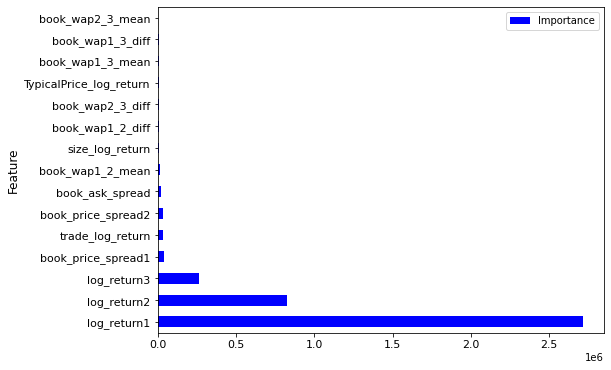

In [5]:
# Train model
cats = ['stock_id']
model_name = 'lgb1'
pred_name = 'pred_{}'.format(model_name)
features_to_consider = [col for col in train.columns if not col in ['time_id', 'target', 'pred_lgb1', 'stock_id']]
print('We consider {} features'.format(features_to_consider))

train[pred_name] = 0
test['target'] = 0

n_folds = 4
n_rounds = 5000
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2016)
scores_folds[model_name] = []
counter = 1
for dev_index, val_index in kf.split(range(len(train))):
    print('CV {}/{}'.format(counter, n_folds))
    X_train = train.loc[dev_index, features_to_consider]
    y_train = train.loc[dev_index, target_name].values
    X_val = train.loc[val_index, features_to_consider]
    y_val = train.loc[val_index, target_name].values
    
    train_data = lgb.Dataset(X_train, label=y_train, weight=1/np.power(y_train, 2))
    val_data = lgb.Dataset(X_val, label=y_val, weight=1/np.power(y_val, 2))
    
    model = lgb.train(params_lgbm, train_data, n_rounds, valid_sets=val_data, feval=feval_RMSPE, verbose_eval=250, early_stopping_rounds=500)
    preds = model.predict(train.loc[val_index, features_to_consider])
    train.loc[val_index, pred_name] = preds
    score = round(rmspe(y_true=y_val, y_pred=preds), 5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    counter += 1
    test[target_name] += model.predict(test[features_to_consider]).clip(0, 1e10)
del train_data, val_data
test[target_name] = test[target_name]/n_folds

score = round(rmspe(y_true=train[target_name].values, y_pred=train[pred_name].values), 5)
print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))
test[['row_id', target_name]].to_csv('submission.csv', index=False)

importances = pd.DataFrame({'Feature': model.feature_name(),
                            'Importance': model.feature_importance(importance_type='gain')})
importances.sort_values(by='Importance', inplace=True)
importances2 = importances.nlargest(50, 'Importance', keep='first').sort_values(by='Importance', ascending=False)
importances2[['Importance', 'Feature']].plot(kind='barh', x='Feature', figsize=(8, 6), color='blue', fontsize=11)
plt.ylabel('Feature', fontsize=12)